# 1. ONNX - Single Shot Detector (SDD)
* https://github.com/onnx/models/blob/main/validated/vision/object_detection_segmentation/ssd/model/ssd-10.onnx

##### Download ONNX

In [1]:
!rm -rf ssd-10.onnx
!wget https://github.com/onnx/models/raw/main/validated/vision/object_detection_segmentation/ssd/model/ssd-10.onnx

--2024-07-25 17:44:04--  https://github.com/onnx/models/raw/main/validated/vision/object_detection_segmentation/ssd/model/ssd-10.onnx
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/onnx/models/main/validated/vision/object_detection_segmentation/ssd/model/ssd-10.onnx [following]
--2024-07-25 17:44:04--  https://media.githubusercontent.com/media/onnx/models/main/validated/vision/object_detection_segmentation/ssd/model/ssd-10.onnx
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80363696 (77M) [application/octet-stream]
Saving to: ‘ssd-10.onnx’

ssd-10.onnx         100%[============

---  

# 2. ONNX --> TensorRT with Polygraphy

##### About 2 minutes

In [2]:
%%time
# 2 minutes

!date

from polygraphy.backend.trt import network_from_onnx_path, CreateConfig, engine_from_network, save_engine

network = network_from_onnx_path('ssd-10.onnx')
config = CreateConfig() # fp16=True)
engine = engine_from_network(network, config)
save_engine(engine, path='ssd-10.trt')

Thu Jul 25 17:44:17 EDT 2024
[W] ModelImporter.cpp:680: Make sure output labels has Int64 binding.
[I] Configuring with profiles:[
        Profile 0:
            {image [min=[1, 3, 1200, 1200], opt=[1, 3, 1200, 1200], max=[1, 3, 1200, 1200]]}
    ]
[W] profileSharing0806 is on by default in TensorRT 10.0. This flag is deprecated and has no effect.
[I] Building engine with configuration:
    Flags                  | []
    Engine Capability      | EngineCapability.STANDARD
    Memory Pools           | [WORKSPACE: 46067.50 MiB, TACTIC_DRAM: 46067.50 MiB, TACTIC_SHARED_MEMORY: 1024.00 MiB]
    Tactic Sources         | [EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [PROFILE_SHARING_0806]
[I] Finished engine building in 37.476 seconds
[I] Saving engine to ssd-10.trt
CPU times: user 16.1 s, sys: 11.3 s, total: 27.4 s
Wall time: 39.3 s


---  

# 3. Infer with TensorRT

In [14]:
from polygraphy.backend.trt import TrtRunner
import tensorrt as trt

from PIL import Image
import numpy as np

### Sample Image

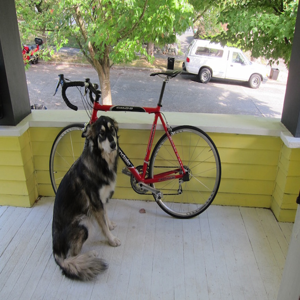

(1, 3, 1200, 1200)

In [15]:
img = Image.open('dog.jpg').resize((1200, 1200))
display(img.resize((300,300)))
img = np.transpose(img, (2, 0, 1))
img = np.array(img).astype(np.float32) / 255.0
img = np.expand_dims(img, axis=0) 
img.shape

### Infer

In [17]:
# load trt file
with open("ssd-10.trt", "rb") as f:
    engine_data = f.read()

# create engine
trt_runtime = trt.Runtime(trt.Logger(trt.Logger.VERBOSE))    
engine = trt_runtime.deserialize_cuda_engine(engine_data)

# infer
with TrtRunner(engine) as runner:
    outputs = runner.infer(feed_dict={"image":np.array(img)})

[07/25/2024-17:49:51] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[07/25/2024-17:49:51] [TRT] [I] Loaded engine size: 102 MiB
[07/25/2024-17:49:51] [TRT] [V] Deserialization required 81988 microseconds.
[07/25/2024-17:49:51] [TRT] [V] Total per-runner device persistent memory is 2572800
[07/25/2024-17:49:51] [TRT] [V] Total per-runner host persistent memory is 178416
[07/25/2024-17:49:51] [TRT] [V] Allocated activation device memory of size 145031168
[07/25/2024-17:49:51] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +141, now: CPU 0, GPU 346 (MiB)
[07/25/2024-17:49:51] [TRT] [V] CUDA lazy loading is enabled.


### Output

In [18]:
print("output keys", dict(outputs).keys())

bboxes = outputs["bboxes"][0]
print("bboxes", bboxes.shape)

scores = outputs["scores"][0]
scores.shape, scores.max(), scores.min()

output keys dict_keys(['bboxes', 'labels', 'scores'])
bboxes (200, 4)


((200,), 0.73044664, 0.05981639)

### Classes / Labels

In [11]:
# https://gist.githubusercontent.com/aallan/fbdf008cffd1e08a619ad11a02b74fa8/raw/4183a4fd800c2d2d6211fd5129bf88d709072564/coco_labels.txt
labels = outputs["labels"][0]

label_list = []

with open("labels.txt", "r") as f:
    for line in f:
        label_list.extend(line.split())
        
label_dict = {idx: class_name for idx, class_name in enumerate(label_list)}

detected_objects = [(lbl_idx, label_dict[lbl_idx], scr) for lbl_idx, scr in  list(zip(labels, scores))]

detected_objects[:5]

[(2, 'car', 0.73044664),
 (3, 'motorcycle', 0.4977617),
 (8, 'boat', 0.4523856),
 (75, 'laptop', 0.37124574),
 (2, 'car', 0.23678774)]

### Visualization


x- 205.59 y- 294.93 w- 736.29 h- 705.27
(2, 'car', 0.73044664)

-------------------------------------



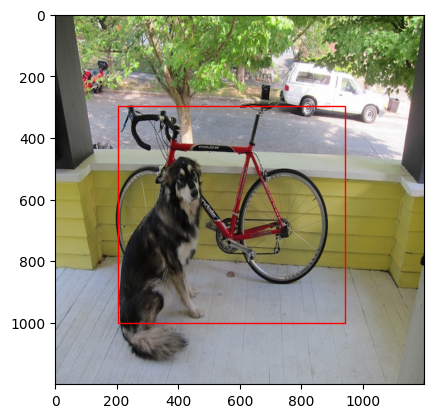

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


scores = outputs["scores"][0]
bboxes = outputs["bboxes"][0]

MAX_BOXES = 1

fig, ax = plt.subplots()
ax.imshow(Image.open('dog.jpg').resize((1200, 1200)))

for inference_idx, score in enumerate(scores[:MAX_BOXES]):
    
    x1 = [coord * 1200 for coord in bboxes[inference_idx]][0]
    y1 = [coord * 1200 for coord in bboxes[inference_idx]][1]
    
    x2 = [coord * 1200 for coord in bboxes[inference_idx]][2]
    y2 = [coord * 1200 for coord in bboxes[inference_idx]][3]
    
    w = x2-x1
    h = y2-y1

    print("\nx-",round(x1,2),"y-",round(y1,2),"w-",round(w,2),"h-",round(h,2))
    
    rect = patches.Rectangle(xy=(x1,y1), width=w, height=h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    print(detected_objects[inference_idx])
    print('\n-------------------------------------\n')

plt.show()
plt.show()